In [1]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set_style("darkgrid")
from sklearn import linear_model
import random
import math
import os

import warnings
warnings.filterwarnings('ignore')


Decripcion de los datos
             year        temp
count   133.00000  133.000000
mean   1946.00000    8.528271
std      38.53786    0.629293
min    1880.00000    6.920000
25%    1913.00000    8.100000
50%    1946.00000    8.430000
75%    1979.00000    8.890000
max    2012.00000   10.410000

Las primeras 8 filas de los datdos
   year  temp
0  1880  7.79
1  1881  8.19
2  1882  8.49
3  1883  7.94
4  1884  7.60
5  1885  8.16
6  1886  7.67
7  1887  8.23


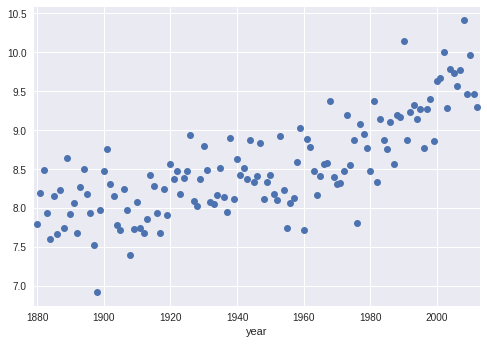

In [2]:
# Levanto los datos
df = pd.read_csv('./data/worldTemperature.csv', ' ', header = None, names = (['year', 'temp']))
print("Decripcion de los datos")
print(df.describe())

print("\nLas primeras 8 filas de los datdos")
print(df.head(8))

# Graficos los datos
ax = sns.tsplot(time=df['year'], data=df['temp'], interpolate=False)
sns.plt.show()

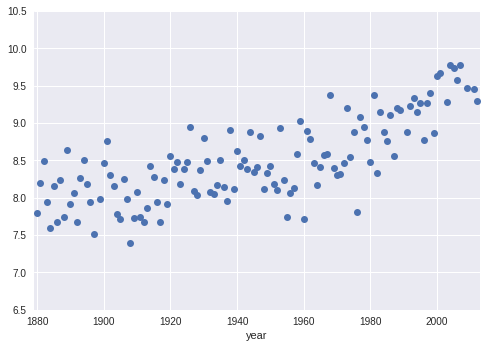

In [3]:
# Limpio los outliers
def mascara_outliers(s):
    return abs(s - s.mean()) <= 2*s.std()
    
mascara = mascara_outliers(df['temp'])
df = df[mascara]
sns.tsplot(time=df['year'], data=df['temp'], interpolate=False)

# Para que se evidencien mejor los outliers que saque, grafico en el mismo rango
# Algunos me parecen que no deberian ser removidos
sns.plt.ylim((6.5, 10.5))
sns.plt.show()

In [37]:
# Uso cuadrados minimos para predecir
sns.tsplot(time=df['year'], data=df['temp'], interpolate=False)

def armar_matriz_A(s):
    temp = []
    for t in s:
        temp.append([20*np.cos(5*t),1000*np.cos(60*t),10*np.sin(50*t),t, 1])
    return np.array(temp)

def entrenar_y_predecir_en_rangos(df, rango_entrenamiento, rango_prediccion):
    regr = linear_model.LinearRegression(fit_intercept=False)

    # Entreno el modelo
    df_e = df[df['year'].isin(rango_entrenamiento)]
    A_e = armar_matriz_A(df_e['year'])
    regr.fit(A_e, df_e['temp'])

    # Me fijo la aproximacion que se realizo
    df_e['p'] = regr.predict(A_e)
    sns.tsplot(time=df_e['year'], data=df_e['p'], color='r')

    # Realizo predicciones
    df_p = df[df['year'].isin(rango_prediccion)]

    A_p = armar_matriz_A(df_p['year'])
    df_p['p'] = regr.predict(A_p)
    sns.tsplot(time=df_p['year'], data=df_p['p'], color='g')

    ECM = sum((df_p['p']-df_p['temp'])**2)
    return ECM

def predecir(k):
    return entrenar_y_predecir_en_rangos(df, range(k-35,k), range(k,k+10))

Error de prediccion: 0.76
Error de prediccion: 2.01
Error de prediccion: 0.53
Error promedio: 1.09917354141


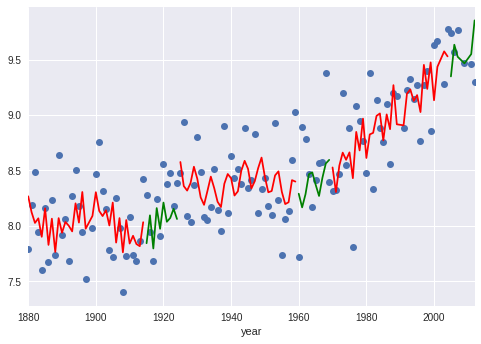

In [5]:

ECM1= predecir(1915)
print("Error de prediccion: {:.2f}".format(ECM1))    

ECM2= predecir(1960)
print("Error de prediccion: {:.2f}".format(ECM2))    

ECM3= predecir(2005)
print("Error de prediccion: {:.2f}".format(ECM3))

print ("Error promedio:",(ECM1+ECM2+ECM3)/3)

sns.plt.xlim((1880, 2012))
sns.plt.show()

In [6]:
#Experimento 2:

In [7]:
#Funciones de entrenamiento y creación de la matriz adaptadas a experimentos multivariados

#S es una matriz. Cada fila contiene X_i grande(un vector de temperaturas por pais para un año determinado)
def armar_matriz_A_multivar(s):
    temp = []
    for t in s:
        #Aca va la familia de funciones, cambiar segun expermiento. 
        #Sin la constante 
        temp.append([t.mean(), 1])
    return np.array(temp)

def entrenar_y_predecir_en_rangos(df, rango_entrenamiento, rango_prediccion, paises):
    regr = linear_model.LinearRegression(fit_intercept=False)
    
    # Entreno el modelo
    df_e = df[df['year'].isin(rango_entrenamiento)]
    df_aux = df_e.ix[:,2:paises + 1]
    
    A_e = armar_matriz_A_multivar(df_aux.values)
    regr.fit(A_e, df_e['world'])

    # Me fijo la aproximacion que se realizo
    df_e['p'] = regr.predict(A_e)
    sns.tsplot(time=df_e['year'], data=df_e['p'], color='r')

    # Realizo predicciones
    df_p = df[df['year'].isin(rango_prediccion)]
    df_aux = df_p.ix[:,2:paises + 1]
    A_p = armar_matriz_A_multivar(df_aux.values)
    df_p['p'] = regr.predict(A_p)
    sns.tsplot(time=df_p['year'], data=df_p['p'], color='g')

    ECM = sum((df_p['p']-df_p['world'])**2)
    return ECM

def predecir(k, paises):
    return entrenar_y_predecir_en_rangos(df, range(k-30,k), range(k,k+10), paises)

Error de prediccion: 1.04
Error de prediccion: 1.55
Error de prediccion: 2.02
Error promedio: 1.53528489099


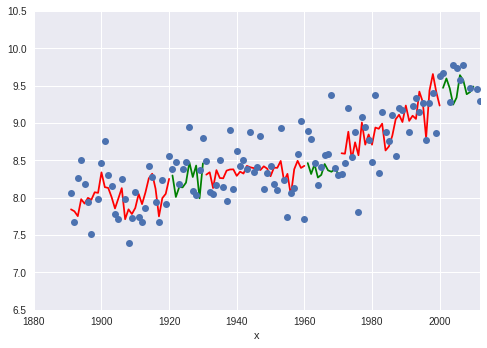

In [13]:
#Idea basica: 
#Elegir representantes caracteristicos de cada clima (porque dicho clima representa la mayor parte del pais)
#Ademas el pais intenta ser lo mas grande posible dentro del clima elegido. 

# Levanto los datos de cada pais, las mediciones son por mes
# Como los años que no aparecen son los mismos para todos, yo tomaría a partir de 1891, que están todos
# Canada:

df_countries = pd.read_csv('./data/paises/Canada.csv',' ',header = None, names = ['year', 'Canada'])
df_countries['year'] = df_countries['year'].map(lambda x: int(math.modf(x)[1]))

# (Notar que este bucle vuelve a levantar Canada.csv)
# Repito para el resto
for filename in os.listdir('./data/paises/'):
    if os.path.isfile('./data/paises/' + filename) and filename != 'Canada.csv':
        aux = pd.read_csv('./data/paises/'+filename,' ',header = None, names = ['year', 'temp'])
        aux['year'] = aux['year'].map(lambda x: int(math.modf(x)[1]))
        filename = filename[:len(filename) - 5]
        df_countries[filename] = aux.temp

# Calculo el promedio anual de cada país
df = df_countries.groupby('year').mean().reset_index()

# Como los datos son consecutivos desde 1891, me quedo con ese subconjunto
df = (df[df['year'].isin(range(1891,2013))]).reset_index()

# Quitar outliers de paises?
# Habría que aplicar la máscara a cada columna (con un bucle como el de arriba, por ej)
# El problema con esto es que remueve el dato para todos los paises
# Es decir, si Canada tiene un outlier en el año 1990, se quita toda esa fila
# Eventualmente, podríamos terminar con muchos menos datos
# ¿Aplicar el promedio general acá y sacar outliers de eso?
# mascara_can = mascara_outliers(df['Canada'])
# df = df[mascara_can]

# Agrego la temperatura del planeta
df_world = pd.read_csv('./data/worldTemperature.csv', ' ', header = None, names = ['x', 'y'])
df_world = (df_world[df_world['x'].isin(range(1891,2013))]).reset_index()
df['world'] = df_world.y

#Filtro outliers del dataframe del mundo
mascara = mascara_outliers(df_world['y'])
df_world = df_world[mascara]
# Se están quitando los outliers a df_world, pero CM utiliza la columna 'world' de df.
# Es decir, no se está haciendo nada

#Ahora aplico CM y grafico:
# Segundo parámetro: cant. de países en el dataframe
ECM1= predecir(1921, 9)
print("Error de prediccion: {:.2f}".format(ECM1))    

ECM2= predecir(1961, 9)
print("Error de prediccion: {:.2f}".format(ECM2))    

ECM3= predecir(2001, 9)
print("Error de prediccion: {:.2f}".format(ECM3))

print ("Error promedio:",(ECM1+ECM2+ECM3)/3)

sns.plt.ylim((6.5, 10.5))
sns.tsplot(time=df_world['x'], data=df_world['y'], interpolate=False)
sns.plt.xlim((1880, 2012))
sns.plt.show()

#Fin expermiento 2

In [53]:
#Idea mejorada:
#Elegir varios representantes de cada clima y promediarlos obteniendo la tempertaura promedio anual de un clima dado.
# Se divide en 3 regiones: Low Latitude, Mid Latitude, High Latitude; que a la vez se subdivide en tres grupos
# Se tienen hasta 9 representantes por cada grupo, hasta 3 por cada subgrupo
# Low Latitude comprende más region, si lo hacemos pesado, debería ser el que tiene más peso

# Inicializo un dataframe para cada region
df_lowLat = pd.read_csv('./data/paises/lowLat/Brasil.csv', ' ',header = None, names = ['year', 'Brasil'])
df_lowLat['year'] = df_lowLat['year'].map(lambda x: int(math.modf(x)[1]))

df_midLat = pd.read_csv('./data/paises/midLat/China.csv', ' ',header = None, names = ['year', 'China'])
df_midLat['year'] = df_midLat['year'].map(lambda x: int(math.modf(x)[1]))

df_highLat = pd.read_csv('./data/paises/highLat/Canada.csv', ' ',header = None, names = ['year', 'Canada'])
df_highLat['year'] = df_highLat['year'].map(lambda x: int(math.modf(x)[1]))

regions = ['lowLat', 'midLat', 'highLat']

for region in regions:
    for filename in os.listdir('./data/paises/' + region + '/'):
        if region == 'lowLat' and filename != 'Brasil.csv':
            aux = pd.read_csv('./data/paises/' + region + '/' filename, ' ', header = None, names = ['year', 'temp'])
            aux['year'] = aux['year'].map(lambda x: int(math.modf(x)[1]))
            filename = filename[:len(filename) - 5]
            df_lowLat[filename] = aux.temp
        elif region == 'midLat' and filename != 'China.csv':
            aux = pd.read_csv('./data/paises/' + region + '/' filename, ' ', header = None, names = ['year', 'temp'])
            aux['year'] = aux['year'].map(lambda x: int(math.modf(x)[1]))
            filename = filename[:len(filename) - 5]
            df_midLat[filename] = aux.temp
        elif region == 'highLat' and filename != 'Canada.csv':
            aux = pd.read_csv('./data/paises/' + region + '/' filename, ' ', header = None, names = ['year', 'temp'])
            aux['year'] = aux['year'].map(lambda x: int(math.modf(x)[1]))
            filename = filename[:len(filename) - 5]
            df_highLat[filename] = aux.temp

# Calculo el promedio anual de los países de cada región
df_lowLat  = df_lowLat.groupby('year').mean()
df_midLat  = df_midLat.groupby('year').mean()
df_highLat = df_highLat.groupby('year').mean()

# Obtengo el promedio anual de cada region
df_lowLat['lowLat']   = df_lowLat.mean(axis = 1)
df_midLat['midLat']   = df_midLat.mean(axis = 1)
df_highLat['highLat'] = df_highLat.mean(axis = 1)

# Necesario para que los años sean una key, y así poder manipularlos mejor (para plotear, por ej)
# En df voy a juntar todo
df         = df_lowLat.reset_index()
df_midLat  = df_midLat.reset_index()
df_highLat = df_highLat.reset_index()

# Auno los dataframes
df['midLat']  = df_midLat.midLat
df['highLat'] = df_highLat.highLat
# Agrego la temperatura del planeta
df_world = pd.read_csv('./data/worldTemperature.csv', ' ', header = None, names = ['year', 'temp'])
df['world'] = df_world.temp
# Y me quedo con lo que me importa
df = df[['year', 'lowLat', 'midLat', 'highLat', 'world']]

# Como los datos son consecutivos desde 1891, me quedo con ese subconjunto
df = df[df['year'].isin(range(1891,2013))]

# Aplicar CM y predecir

#Funciones posibles(cada una de ellas es un experimento distinto, no necesariamente reportable (nos quedamos con el mejor): 
#Promedio asi nomas
#Promedio pesado
#Promedio pesado + cte
#mas...
#TODO
